# Analysis & Visualization of Produced Water Chemistry for Environmental & Agricultural Utilization

## SETUP

In [1]:
# Dependencies
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import sklearn

from wqchartpy import triangle_piper
from wqchartpy import contour_piper
from contour_piper_modified import plot as contour_piper_mod
from wqchartpy import color_piper

import warnings
warnings.filterwarnings("ignore")


## DATA CLEANING & FILTERING

### Read in CSV Files & Merge to Initial Raw Dataframe

In [2]:
# Load the data from the CSV files
df1 = pd.read_csv('../data/split_1_USGSPWDBv2.3n.csv', low_memory=False)
df2 = pd.read_csv('../data/split_2_USGSPWDBv2.3n.csv', low_memory=False)
df3 = pd.read_csv('../data/split_3_USGSPWDBv2.3n.csv', low_memory=False)

# Concatenate the dataframes
frames = [df1, df2, df3]
df_merged = pd.concat(frames, ignore_index=True)

# Save the concatenated dataframe to a new CSV file
df_merged.to_csv('../data/df_csv_files/df_merged.csv', index=False)


### Adjust Columns

In [3]:
# List of columns to be removed
columns_to_remove = [
    "IDDB", "SOURCE", "REFERENCE", "LATLONGAPX", "USGSREGION", "BASINCODE", 
    "STATECODE", "COUNTYCODE", "FIELD", "FIELDCODE", "WELLCODE", "TOWNRANGE", 
    "REGDIST", "LOC", "QUAD", "DAY", "DATECOMP", "DATEANALYS", "METHOD", 
    "OPERATOR", "PERMIT", "DFORM", "GROUP", "MEMBER", "AGECODE", "ERA", 
    "PERIOD", "EPOCH", "LAB", "REMARKS", "LITHOLOGY", "POROSITY", "TEMP", 
    "PRESSURE", "SG", "SPGRAV", "SPGRAVT", "RESIS", "RESIST", "PH", "PHT", 
    "EHORP", "COND", "CONDT", "TURBIDITY", "HEM", "MBAS","TDS","TDSCALC", "TSS", "CHARGEBAL", 
    "ACIDITY", "DIC", "DOC", "TOC", "CN", "BOD", "COD", "BENZENE", "TOLUENE", 
    "ETHYLBENZ", "XYLENE", "ACETATE", "BUTYRATE", "FORMATE", "LACTATE", 
    "PHENOLS", "PERC", "PROPIONATE", "PYRUVATE", "VALERATE", "ORGACIDS", 
    "Ar", "CH4", "C2H6", "CO2", "H2", "H2S", "He", "N2", "NH3", "O2", "ALPHA", 
    "BETA", "dD", "H3", "d7Li", "d11B", "d13C", "C14", "d18O", "d34S", 
    "d37Cl", "K40", "d81Br", "Sr87Sr86", "I129", "Rn222", "Ra226", "Ra228", 
    "cull_PH", "cull_MgCa", "cull_KCl", "cull_K5Na", "Ag", "Al", "As", "Au", 
    "B", "BO3", "Be", "Bi", "Cd", "Co", "Cr", "Cs", "Cu", "F", "FeS", "FeAl", 
    "FeAl2O3", "Hg", "I", "Mn", "Mo", "N", "NO2", "NO3", "NO3NO2", "NH4", 
    "TKN", "Ni", "OH", "P", "PO4", "Pb", "Rh", "Rb", "S", "SO3", "HS", "Sb", 
    "Sc", "Se", "Sn", "Ti", "Tl", "U", "V", "W", "Zn"
]

# Remove the specified columns
df_limited_column = df_merged.drop(columns=columns_to_remove, errors='ignore')

# Display the updated merged dataframe
df_limited_column.to_csv('../data/df_csv_files/df_limited_column.csv', index=False)


In [4]:
# Add column "BASIN_CATEGORY" to df_filtered to aid in later filtering

# Define the basin categories
basin_categories = {
    'Anadarko Basin': ['Amarillo Arch', 'Anadarko', 'Anadarko - Chautauqua Platform', 'Anadarko - Southern Oklahoma'],
    'Appalachian Basin': ['Appalachian', 'Black Warrior'],
    'Gulf Coast Basin': ['Arkla', 'Gulf Coast'],
    'Oklahoma Platform Basins': ['Arkoma', 'Arkoma - Chautauqua Platform', 'Central Kansas Uplift', 
                                                'Chautauqua Platform', 'Cherokee', 'Kansas Basins', 'Nemaha Uplift', 
                                                'Sedgwick', 'Southern Oklahoma'],
    'Fort Worth Basin': ['Bend Arch', 'Fort Worth'],
    'Rocky Mountain Basins': ['Big Horn', 'Black Mesa', 'Denver', 'Green River', 'Paradox', 'Piceance', 
                              'Powder River', 'San Juan', 'Uinta', 'Wind River'],
    'Illinois Basin': ['Illinois'],
    'Michigan Basin': ['Michigan'],
    'Permian Basin': ['Palo Duro', 'Permian'],
    'Williston Basin': ['Williston']
}

# Create a reverse mapping from specific basin to category
basin_to_category = {specific: category for category, specifics in basin_categories.items() for specific in specifics}

df_basins_categorized = df_limited_column.copy()

# Map the 'BASIN' column to a new 'BASIN_CATEGORY' column
df_basins_categorized['BASIN_CATEGORY'] = df_basins_categorized['BASIN'].map(basin_to_category)

# Drop rows that don't have a basin category (i.e., not in your list)
df_basins_categorized = df_basins_categorized.dropna(subset=['BASIN_CATEGORY'])

# Save the filtered dataframe to a new CSV file
df_basins_categorized.to_csv('../data/df_csv_files/df_basins_categorized.csv', index=False)


### Technical Cleaning Steps

In [5]:
# Remove rows where TDSUSGS <= 35000 (sea water to eliminate all coalebed methane produced water and also the failing analyses)
df_filtered = df_basins_categorized[df_basins_categorized['TDSUSGS'] > 35000]

# Save the filtered dataframe to a new CSV file
df_filtered.to_csv('../data/df_csv_files/df_filtered_TDS.csv', index=False)


In [6]:
# Fill NaN values in 'KNa', 'K', 'Na', 'Ca', 'Cl', 'SO4', 'Mg' with zeros for calculation
for col in ['KNa', 'K', 'Na', 'Ca', 'Cl', 'SO4', 'Mg']:
    df_filtered[col].fillna(0, inplace=True)

# First, we'll fill NaN values in 'KNa' and 'K' with zeros for the calculation.
df_filtered['KNa'].fillna(0, inplace=True)
df_filtered['K'].fillna(0, inplace=True)

# Apply conditions to calculate 'Na'
# If 'Na' is missing and both 'KNa' and 'K' are present, populate 'Na' with 'KNa' - 'K'
# If 'Na' is missing and 'KNa' is present but 'K' is not, populate 'Na' with 'KNa'

na_mask = df_filtered['Na'].isna()
na_present = df_filtered['Na'] > 0
kna_present = df_filtered['KNa'] > 0
k_present = df_filtered['K'] > 0
k_missing = df_filtered['K'] == 0

df_filtered.loc[k_missing & na_present & kna_present, 'K'] = df_filtered['KNa'] - df_filtered['Na']
df_filtered.loc[na_mask & kna_present & k_present, 'Na'] = df_filtered['KNa'] - df_filtered['K']
df_filtered.loc[na_mask & kna_present & ~k_present, 'Na'] = df_filtered['KNa']

# Remove rows where 'Na' is still missing
df_filtered.dropna(subset=['Na'], inplace=True)

# Remove rows where 'Cl' is missing
df_filtered.dropna(subset=['Cl'], inplace=True)

# Save the updated dataframe 
df_filtered.to_csv('../data/df_csv_files/df_filtered_Na_Cl.csv', index=False)


In [7]:
#To calculate the molar concentrations from concentrations given in ppm (parts per million) or mg/L,
#these values need to be converted into moles per liter (M). The formula to convert ppm or mg/L to M is:

                #Molarity (M)=Concentration (mg/L)/ Molar Mass (g/mol) 

#This calculation assumes that 1 ppm is equivalent to 1 mg/L. The molar mass of each element or compound (Na, Ca, Cl, SO4, and Mg) 
#is a constant value based on its atomic or molecular weight.

#Apply the conditions (molar Na > molar Ca) and (molar Cl > molar SO4) and (molar Ca > molar Mg/2) which represent likely unnatural combinations
# Convert concentrations from ppm (mg/L) to Molarity (M)
molar_masses = {'Na': 22.99, 'Ca': 40.08, 'Cl': 35.45, 'SO4': 96.06, 'Mg': 24.305}
for element, molar_mass in molar_masses.items():
    df_filtered[element + '_M'] = df_filtered[element] / molar_mass

# Apply the conditions (molar Na > molar Ca) and (molar Cl > molar SO4) and (molar Ca > molar Mg/2)
condition = (df_filtered['Na_M'] > df_filtered['Ca_M']) & \
            (df_filtered['Cl_M'] > df_filtered['SO4_M']) & \
            (df_filtered['Ca_M'] > df_filtered['Mg_M'] / 2)

df_filtered = df_filtered[condition]

# Save the updated dataframe
df_filtered.to_csv('../data/df_csv_files/df_filtered_corrected_elemental_ratios.csv', index=False)


In [8]:
# Filter out rows where USGS charge balance is not between -10 and +10
df_filtered = df_filtered[df_filtered['chargebalance'].between(-10, 10)]

# Save the updated dataframe
df_filtered.to_csv('../data/df_csv_files/df_filtered_chargebalance.csv', index=False)


In [9]:
# Calculate charge balance
df_filtered['Cations'] = (df_filtered['Na_M'] * 1) + (df_filtered['Ca_M'] * 2) + (df_filtered['Mg_M'] * 2)
df_filtered['Anions'] = (df_filtered['Cl_M'] * 1) + (df_filtered['SO4_M'] * 2)
df_filtered['CalculatedChargeBalance'] = ((df_filtered['Cations'] - df_filtered['Anions']) / (df_filtered['Cations'] + df_filtered['Anions'])) * 100

# Flag discrepancies between calculated charge balance and existing 'chargebalance' column
threshold = 5  # 5% threshold for discrepancy
df_filtered['ChargeBalanceDiscrepancy'] = abs(df_filtered['CalculatedChargeBalance'] - df_filtered['chargebalance']) > threshold

# Save the updated dataframe with discrepancy flags
df_filtered.to_csv('../data/df_csv_files/df_filtered_discrepancy_flags.csv', index=False)


In [10]:
#Replace missing CO3 with 0's
df_filtered['CO3'].fillna(0, inplace=True)

#Replace missing HCO3 with ALKHCO3 where available
df_filtered['HCO3'].fillna(df_filtered['ALKHCO3'], inplace=True)

#Calculate HCO3 if both HCO3 and ALKHCO3 are missing
mask = df_filtered['HCO3'].isna() & df_filtered['ALKHCO3'].isna()
df_filtered.loc[mask, 'HCO3'] = (df_filtered['Cations'] - df_filtered['Anions']) / 61.0702

# Save the updated dataframe with estimated HCO3
df_filtered.to_csv('../data/df_csv_files/df_filtered_estimated_HCO3.csv', index=False)


### Filtered Dataframe Variations

In [11]:
# Create version of df_filtered that drops all columns without a basin category

df_filtered_categorized_basin = df_filtered.copy()

# Drop rows that don't have a basin category 
df_filtered_categorized_basin = df_filtered_categorized_basin.dropna(subset=['BASIN_CATEGORY'])

# Save the filtered dataframe to a new CSV file
df_filtered_categorized_basin.to_csv('../data/df_csv_files/df_filtered_categorized_basin.csv', index=False)


In [12]:
# Create version of df_filtered with only the most recent sample from each well

# Convert 'DATESAMPLE' to DateTime format for rows where it's available
df_filtered['DATESAMPLE'] = pd.to_datetime(df_filtered['DATESAMPLE'], errors='coerce')

# Split the DataFrame into two: one where DATESAMPLE is available, and one where it's missing
df_with_date = df_filtered.dropna(subset=['DATESAMPLE'])
df_without_date = df_filtered[df_filtered['DATESAMPLE'].isna()]

# For wells with dates, find the index of the most recent sample
idx_with_date = df_with_date.groupby('WELLNAME')['DATESAMPLE'].idxmax()

# For wells without dates, simply take the last occurrence
idx_without_date = df_without_date.groupby('WELLNAME').tail(1).index

# Combine the indices
combined_idx = idx_with_date.tolist() + idx_without_date.tolist()

# Use the combined indices to filter the DataFrame
df_filtered_recent = df_filtered.loc[combined_idx]

# Save the filtered dataframe to a new CSV file
df_filtered_recent.to_csv('../data/df_filtered_recent.csv', index=False)


In [13]:
# Create version of df_filtered_recent that drops all columns without a basin category

df_filtered_recent_categorized_basin = df_filtered_recent.copy()

# Drop rows that don't have a basin category 
df_filtered_recent_categorized_basin = df_filtered_recent_categorized_basin.dropna(subset=['BASIN_CATEGORY'])

# Save the filtered dataframe to a new CSV file
df_filtered_recent_categorized_basin.to_csv('../data/df_csv_files/df_filtered_recent_categorized_basin.csv', index=False)


## ANALYSIS 

### Descriptive Statistics

In [14]:
#Descriptive Statistics of columns with numerical data
descriptive_stats = df_filtered.describe()
descriptive_stats


IDUSGS      LATITUDE     LONGITUDE  TIMESERIES    DEPTHUPPER  \
count   46568.000000  40456.000000  40693.000000   66.000000  37711.000000   
mean    56730.645164     37.364217    -97.708347    6.000000   6371.373993   
std     30943.257029      6.747505      6.275761    3.687818   3267.379543   
min        65.000000     26.022340   -111.140870    1.000000      8.000000   
25%     31757.750000     31.960900   -102.860840    3.000000   3570.000000   
50%     61977.500000     35.612000    -98.035000    5.000000   6160.000000   
75%     81419.250000     43.498275    -93.150200    8.000000   8888.000000   
max    114811.000000     49.684620    -75.880000   15.000000  22940.000000   

         DEPTHLOWER     DEPTHWELL     ELEVATION        TDSUSGS  chargebalance  \
count  32477.000000  19634.000000  11481.000000   46568.000000   46568.000000   
mean    6708.026184   7121.064047   1752.774061  162857.364220      -0.026982   
std     3263.024529   3299.554336   1515.930308   91366.732881       1.158768   
min      125.000000    100.000000      0.000000   35006.000000     -10.000000   
25%     3996.000000   4557.000000    345.000000   84090.000000       0.000000   
50%     6499.000000   6767.500000   1573.000000  147051.500000       0.000000   
75%     9140.000000   9210.000000   2546.000000  230184.750000       0.000000   
max    23135.000000  23258.000000   9525.000000  528724.000000      10.000000   

       ...            Sr      ALKHCO3          Na_M          Ca_M  \
count  ...   4811.000000   706.000000  46568.000000  46568.000000   
mean   ...    663.073582   459.366613   2145.184368    245.798266   
std    ...    915.674409   607.546106   1183.259837    258.133003   
min    ...      0.142090     4.000000     75.685080      0.074850   
25%    ...    124.980000   100.000000   1182.167247     64.118825   
50%    ...    339.000000   230.000000   1979.769682    167.153194   
75%    ...    900.000000   559.500000   2832.253154    331.094062   
max    ...  13100.000000  6124.272616   6517.435842   2120.009980   

               Cl_M         SO4_M          Mg_M       Cations        Anions  \
count  46568.000000  46568.000000  46568.000000  46568.000000  46568.000000   
mean    2757.982086      9.434100     65.293236   2767.367371   2776.850287   
std     1572.139294     15.461988     63.223077   1550.991526   1567.235708   
min       18.702398      0.000000      0.000000     78.934473     18.702398   
25%     1411.546897      0.382209     22.587945   1436.310987   1432.466251   
50%     2499.294781      3.216740     49.454845   2512.270360   2513.692187   
75%     3892.806770     11.453675     88.870603   3898.659838   3908.548965   
max     9246.182133    230.605871   1065.783172   9140.344880   9246.182133   

       CalculatedChargeBalance  
count             46568.000000  
mean                 -0.025168  
std                   1.785653  
min                 -88.904190  
25%                  -0.053417  
50%                   0.029520  
75%                   0.167411  
max                  86.956821  

[8 rows x 36 columns]

In [15]:
#Descriptive Statistics of only elements of primary interest
specific_columns_stats = df_filtered[['Li','Na', 'Mg','Ca', 'Cl', 'SO4', 'HCO3']].describe()
specific_columns_stats


Li             Na            Mg            Ca             Cl  \
count  2886.000000   46568.000000  46568.000000  46568.000000   46568.000000   
mean     39.614413   49317.788612   1586.952093   9851.594495   97770.464964   
std      83.158328   27203.143655   1536.636896  10345.970743   55732.337970   
min       0.007100    1740.000000      0.000000      3.000000     663.000000   
25%       5.557500   27178.025000    549.000000   2569.882500   50039.337500   
50%      14.000000   45514.905000   1202.000000   6699.500000   88600.000000   
75%      43.000000   65113.500000   2160.000000  13270.250000  138000.000000   
max    1730.000000  149835.850000  25903.860000  84970.000000  327777.156600   

                SO4          HCO3  
count  46568.000000  46568.000000  
mean     906.239668    321.442235  
std     1485.278608    871.633322  
min        0.000000    -33.126360  
25%       36.715000     61.000000  
50%      309.000000    162.465000  
75%     1100.240000    336.102500  
max    22152.000000  55266.000000

### Define Image File Moving Function Used in Later Code

In [16]:
'''
    Because wqchartpy and plt.savefig() automatically generate the plot image files within the current directory as part of the module code, the following function is needed to push 
    them to our images folder as they're generated to keep our file structure organized automatically. A function was created since this will be used repeatedly.

    Additionally, this helps to consolodate the added complication of needing to go up a folder before going back down for non-wqchartpy images.
'''

def move_image_file_to_images_folder(image_file_name, image_type):
    current_directory = os.getcwd()
    parent_directory = os.path.dirname(current_directory)
    current_file_path = os.path.join(parent_directory, 'notebooks', image_file_name)
    image_folder_path = os.path.join(parent_directory, 'images')
    piper_folder_path = os.path.join(parent_directory, 'images', 'piper_plots')
    geo_folder_path = os.path.join(parent_directory, 'images', 'geo_plots')
    linreg_folder_path = os.path.join(parent_directory, 'images', 'linear_regressions')

    # Check if the images folder exists; if not, it gets created
    if not os.path.exists(image_folder_path):
        os.makedirs(image_folder_path)

    '''
    # Defining function to check if a file with the same name already exists in the destination folder; if so ask user what to do: override with or without deleting the newly generated image
    def prompt_user_if_file_already_exists(image_file_name, destination_folder_name, current_directory, current_file_path):
        if os.path.exists(new_file_path):
            user_input = input(f"A file with the name '{image_file_name}' already exists in '{destination_folder_name}' folder. Do you want to override it? (y/n): ").lower()
        if user_input != 'y':
            user_input = input(f'Do you want to delete the newly generated image file? (y/n): ').lower()
            if user_input == 'y':
                os.remove(current_file_path)
                print('File deleted.')
                return
            else:
                print(f'File not deleted. It is located in {current_directory}.')
            print(f"File not moved to 'images/{destination_folder_name}' folder. It is located in {current_directory}.")
            return
    '''

    if image_type == 'piper':
        
        # Check if image type subfolder exists; if not, it gets created
        if not os.path.exists(piper_folder_path):
            os.makedirs(piper_folder_path)

        new_file_path = os.path.join(piper_folder_path, image_file_name)
        
        '''# Check if a file with the same name already exists in the destination folder; if so ask user what to do: override with or without deleting the newly generated image
        destination_folder_name = 'piper_plots'
        prompt_user_if_file_already_exists(image_file_name, destination_folder_name, current_directory, current_file_path)'''
        
        # Move the file to the destination folder
        os.rename(current_file_path, new_file_path)
        print(f"File '{image_file_name}' moved to 'images/piper_plots' folder.")
        print('---')

    elif image_type == 'geo':
        
        # Check if image type subfolder exists; if not, it gets created
        if not os.path.exists(geo_folder_path):
            os.makedirs(geo_folder_path)

        new_file_path = os.path.join(geo_folder_path, image_file_name)
        
        '''# Check if a file with the same name already exists in the destination folder; if so ask user what to do: override with or without deleting the newly generated image
        destination_folder_name = 'geo_plots'
        prompt_user_if_file_already_exists(image_file_name, destination_folder_name, current_directory, current_file_path)'''
        
        # Move the file to the destination folder
        os.rename(current_file_path, new_file_path)
        print(f"File '{image_file_name}' moved to 'images/geo_plots' folder.")
        print('---')

    elif image_type == 'linreg':
        
        # Check if image type subfolder exists; if not, it gets created
        if not os.path.exists(linreg_folder_path):
            os.makedirs(linreg_folder_path)        

        new_file_path = os.path.join(linreg_folder_path, image_file_name)
        
        '''# Check if a file with the same name already exists in the destination folder; if so ask user what to do: override with or without deleting the newly generated image
        destination_folder_name = 'linear_regressions'
        prompt_user_if_file_already_exists(image_file_name, destination_folder_name, current_directory, current_file_path)'''
        
        # Move the file to the destination folder
        os.rename(current_file_path, new_file_path)
        print(f"File '{image_file_name}' moved to 'images/linear_regressions' folder.")
        print('---')

    elif image_type == 'other':
        # No image type subfolder will be created for 'other' argument; files will be moved to main 'images' folder
        new_file_path = os.path.join(image_folder_path, image_file_name)

        '''# Check if a file with the same name already exists in the destination folder; if so ask user what to do: override with or without deleting the newly generated image
        destination_folder_name = 'images'
        prompt_user_if_file_already_exists(image_file_name, destination_folder_name, current_directory, current_file_path)'''
            
        # Move the file to the destination folder
        os.rename(current_file_path, new_file_path)
        print(f"File '{image_file_name}' moved to 'images' folder.")
        print('---')
        
    else:
        print(f'Invalid image type provided. The available options for image_type are:')
        print(f"'piper', 'geo', 'linreg', 'other'")
        return


### Box & Violin Plots

### Linear Regressions

## VISUALIZATION

### Clustering

### Functions Used in Piper Plot Generation

In [17]:
def generate_single_basin_df_with_wqchartpy_required_format(df, basin):
    
    # Filter input dataframe to only show the basin provided; if 'all' is provided, skip
    mask = df['BASIN_CATEGORY'] == basin
    df_basin = df[mask]

    # If the basin mask returns an empty dataframe, kill the code from continuing to run and display error message
    if df_basin.all().all():
        print(f'"{basin}" does not exist in the "BASIN_CATEGORY" column in the provided dataframe. Check your spelling/case, or provide a different basin name.')
        print(' ')
        basin_avail = df['BASIN_CATEGORY'].unique()
        print(f'The available options in the provided dataframe are:')
        print(f'{basin_avail}')
        return

    '''
    # The below list of column names is just to document the required column names and column order to feed into wqchartpy - variable is not used; just here for reference
    columns_for_wqchartpy = ['Sample', 'Label', 'Marker', 'Size', 'Color', 'Alpha', 'Ca', 'Mg', 'Na', 'K', 'HCO3', 'CO3', 'Cl', 'SO4']
    # The below list of column names is just to document the column names from the USGS data that will be used to feed into the wqchartpy formatted df - variable is not used; just here for reference
    columns_from_usgs = ['IDUSGS', 'Ca', 'Mg', 'Na', 'K', 'HCO3', 'CO3', 'Cl', 'SO4']
    '''

    # Create new dataframe to match format required by wqchartpy for the contour piper plot
    df_wqchartpyformat = pd.DataFrame()

    df_wqchartpyformat = pd.DataFrame()
    df_wqchartpyformat['Sample'] = df_basin['IDUSGS'].map(str)
    df_wqchartpyformat['Label'] = 'sample'
    df_wqchartpyformat['Marker'] = 'o'
    df_wqchartpyformat['Color'] = '#FFFF00'
    df_wqchartpyformat['Size'] = 10
    df_wqchartpyformat['Alpha'] = 0.5

    elements = ['Ca', 'Mg', 'Na', 'K', 'HCO3', 'CO3', 'Cl', 'SO4']
    for element in elements:
        df_wqchartpyformat[element] = df_basin[element]

    # Reset the index
    df_wqchartpyformat.reset_index(inplace=True, drop=True)

    print(f'A dataframe called df_wqchartpyformat has been created that contains {len(df_wqchartpyformat)} samples from the {basin}.')
    print('---')

    return df_wqchartpyformat


In [1]:
def generate_single_basin_piper_plot(df, basin, piper_type, image_name, image_type):
    
    df_wqchartpyformat = generate_single_basin_df_with_wqchartpy_required_format(df, basin)
    
    print('Patience please. The piper plot code may take a while to run.')
    print('---')

    if piper_type == 'triangle':
        triangle_piper.plot(df_wqchartpyformat,unit='mg/L',figname=image_name,figformat='png')
    elif piper_type == 'contour':
        contour_piper_mod(df_wqchartpyformat,unit='mg/L',figname=image_name,figformat='png')
    elif piper_type == 'color':
        color_piper.plot(df_wqchartpyformat,unit='mg/L',figname=image_name,figformat='png')
    else:
        print(f"Piper plot type provided is not a valid option. Please input 'triangle', 'contour', or 'color'.")
        return

    plt.text(0.05, 0.85, f'{basin}', color='black', fontsize=12, ha='left', transform=plt.gcf().transFigure)
    plt.text(0.05, 0.83, f'# Samples: {len(df_wqchartpyformat):,}', color='black', fontsize=10, ha='left', transform=plt.gcf().transFigure)
    # Add labels to contour lines
    plt.clabel(contours, inline=True, fontsize=8)
    
    plt.savefig(f'{image_name}.png', format='png', bbox_inches='tight', dpi=300)
    plt.show()

    image_file_name = f'{image_name}.png'
    move_image_file_to_images_folder(image_file_name, image_type)
    

### Generate Contour Piper Plots: All Samples From Each Well

In [19]:
# # Generate all basin category contour piper plots that include all samples from each well
# basins = df_filtered_categorized_basin['BASIN_CATEGORY'].unique()

# for basin in basins:
#     basin = basin
#     piper_type = 'contour'
#     image_name = f'{basin.replace(" ", "")}_AllWellSamples_Piper(Contour)'
#     image_type = 'piper'
#     generate_single_basin_piper_plot(df_filtered_categorized_basin, basin, piper_type, image_name, image_type)
    

### Generate Colorful Piper Plots: All Samples From Each Well

In [20]:
# # Generate all basin category color piper plots that include all samples from each well
# basins = df_filtered_categorized_basin['BASIN_CATEGORY'].unique()

# for basin in basins:
#     basin = basin
#     piper_type = 'color'
#     image_name = f'{basin.replace(" ", "")}_AllWellSamples_Piper(Color)'
#     image_type = 'piper'
#     generate_single_basin_piper_plot(df_filtered_categorized_basin, basin, piper_type, image_name, image_type)
    

### Generate Triangle Piper Plots: All Samples From Each Well

In [21]:
# # Generate all basin triangle piper plots
# basins = df_filtered_categorized_basin['BASIN_CATEGORY'].unique()

# for basin in basins:
#     basin = basin
#     piper_type = 'triangle'
#     image_name = f'{basin.replace(" ", "")}_AllWellSamples_Piper(Triangle)'
#     image_type = 'piper'
#     generate_single_basin_piper_plot(df_filtered_categorized_basin, basin, piper_type, image_name, image_type)
    

### Generate Contour Piper Plots: Most Recent Sample From Each Well Only

A dataframe called df_wqchartpyformat has been created that contains 7589 samples from the Gulf Coast Basin.
---
Patience please. The piper plot code may take a while to run.
---
Contour-filed Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



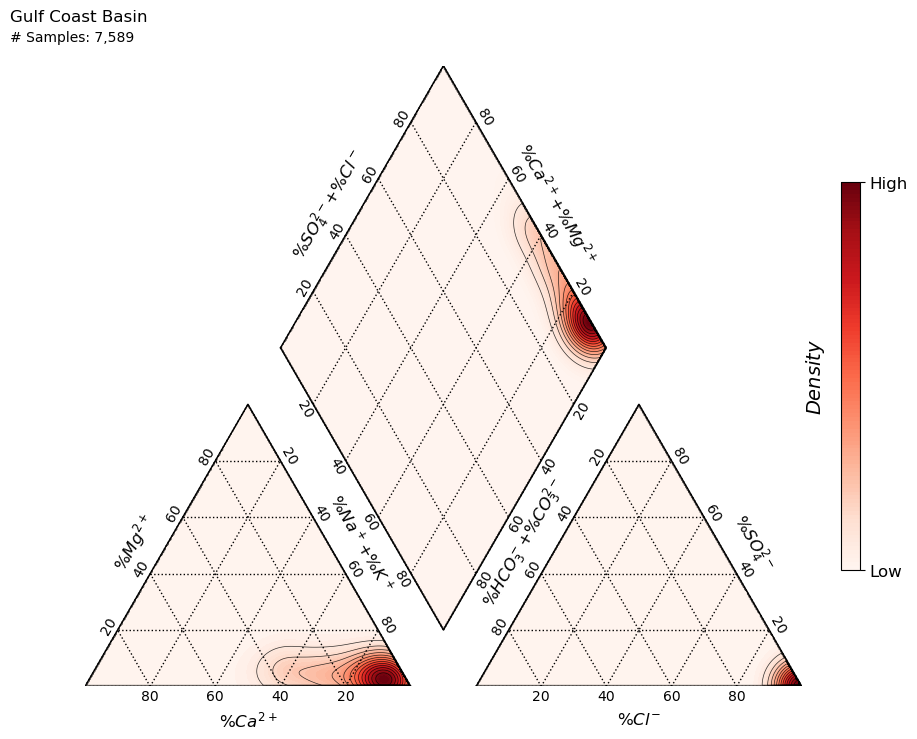

File 'GulfCoastBasin_OnlyMostRecentWellSamples_Piper(Contour).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 4378 samples from the Permian Basin.
---
Patience please. The piper plot code may take a while to run.
---
Contour-filed Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



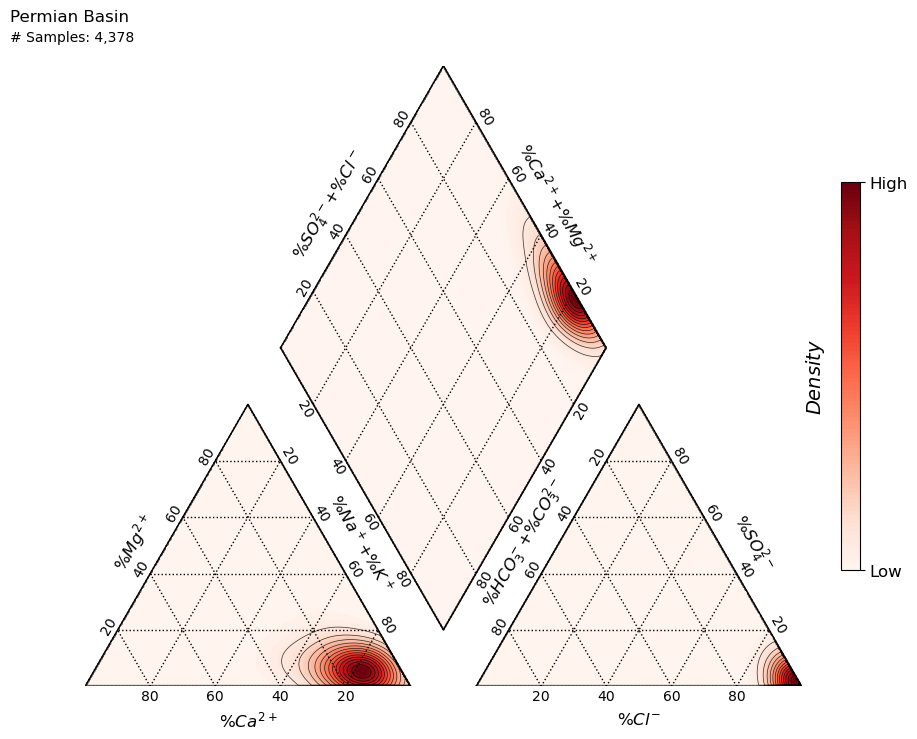

File 'PermianBasin_OnlyMostRecentWellSamples_Piper(Contour).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 3582 samples from the Williston Basin.
---
Patience please. The piper plot code may take a while to run.
---
Contour-filed Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



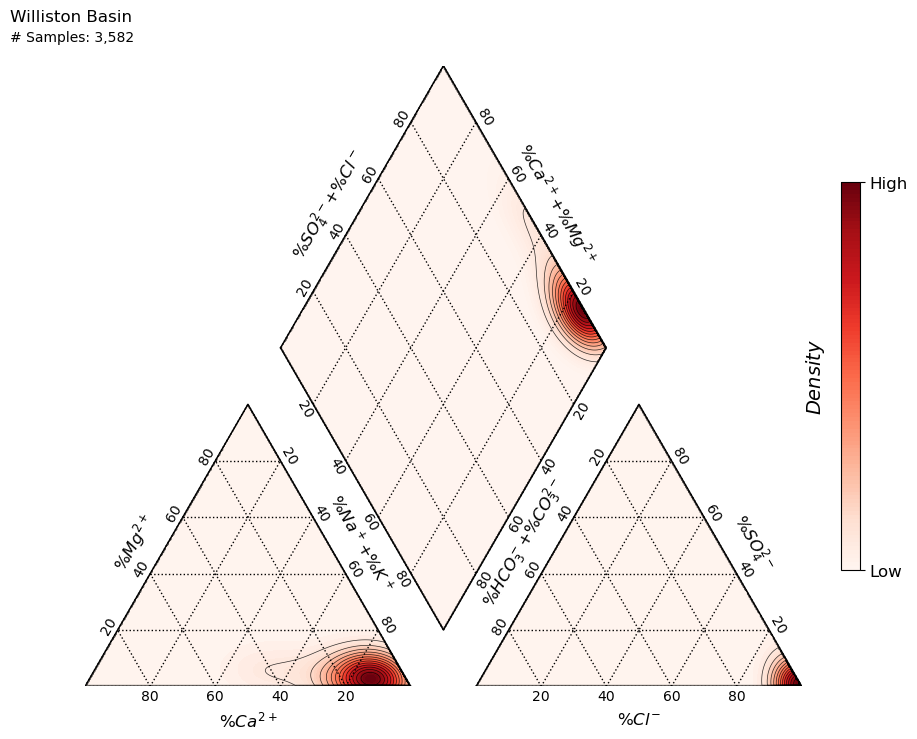

File 'WillistonBasin_OnlyMostRecentWellSamples_Piper(Contour).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 1715 samples from the Rocky Mountain Basins.
---
Patience please. The piper plot code may take a while to run.
---
Contour-filed Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



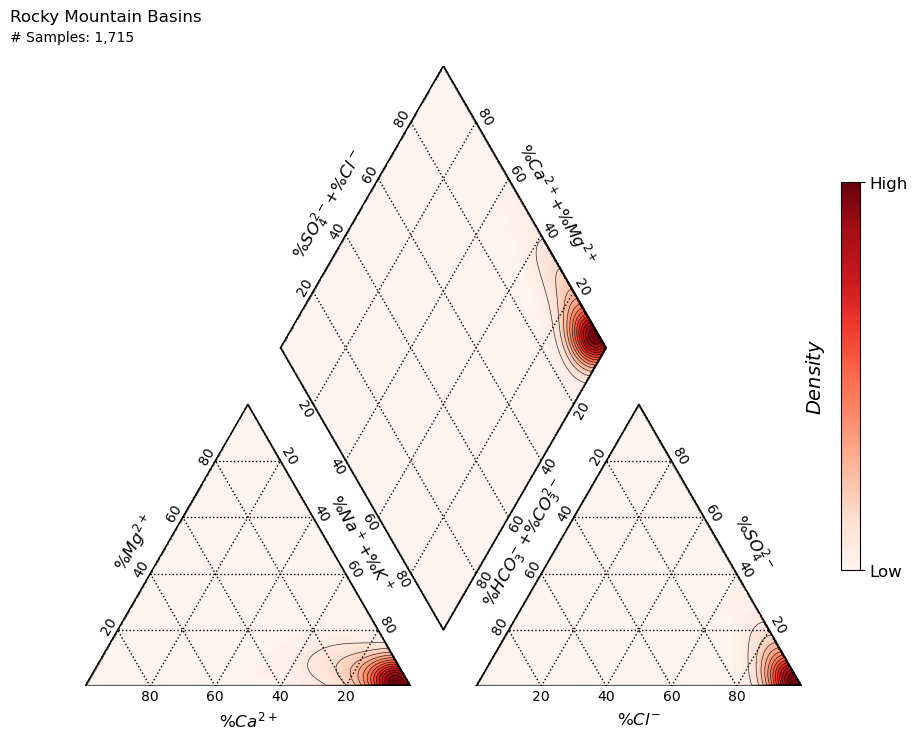

File 'RockyMountainBasins_OnlyMostRecentWellSamples_Piper(Contour).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 5876 samples from the Oklahoma Platform Basins.
---
Patience please. The piper plot code may take a while to run.
---
Contour-filed Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



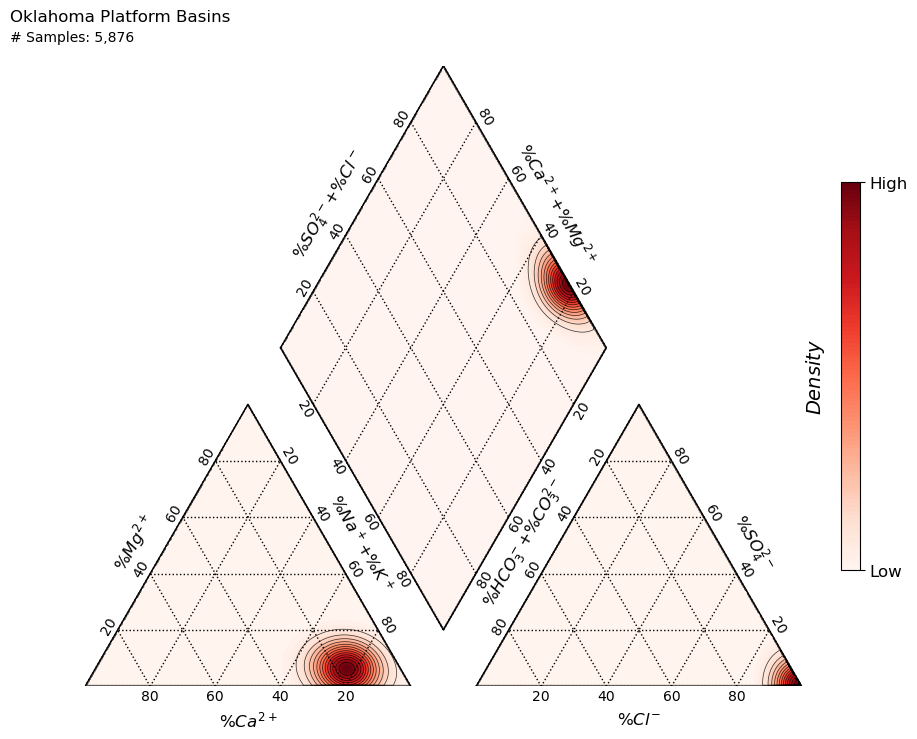

File 'OklahomaPlatformBasins_OnlyMostRecentWellSamples_Piper(Contour).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 1460 samples from the Anadarko Basin.
---
Patience please. The piper plot code may take a while to run.
---
Contour-filed Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



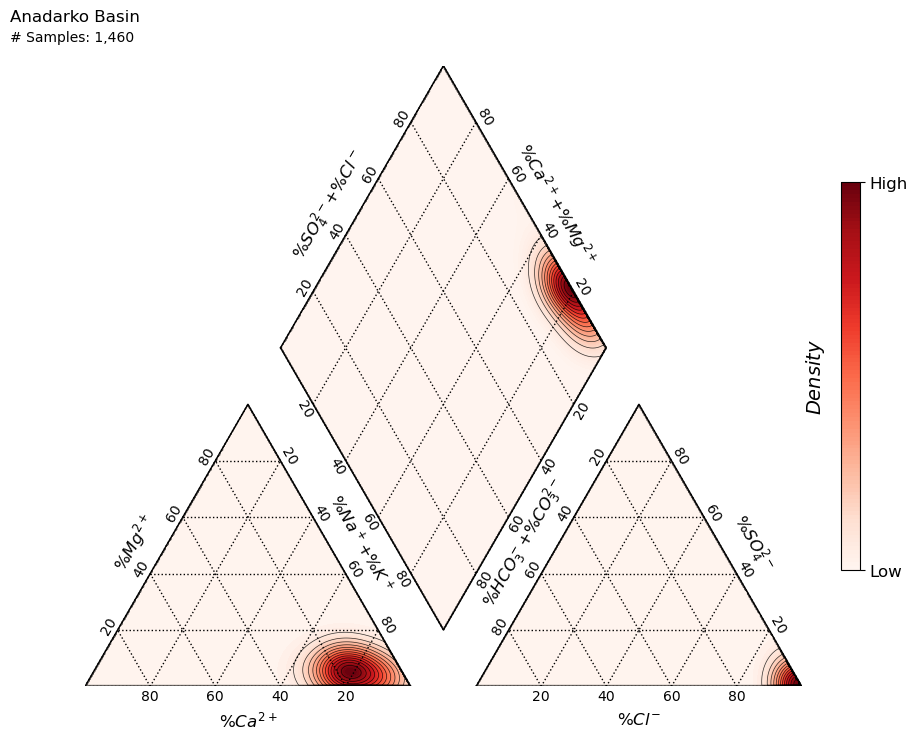

File 'AnadarkoBasin_OnlyMostRecentWellSamples_Piper(Contour).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 866 samples from the Illinois Basin.
---
Patience please. The piper plot code may take a while to run.
---
Contour-filed Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



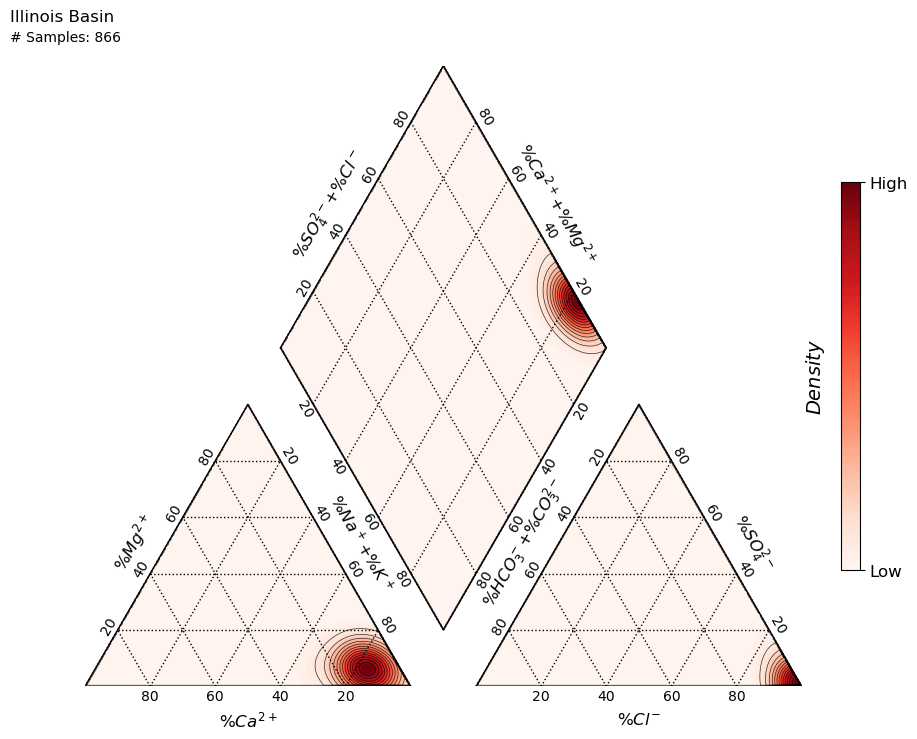

File 'IllinoisBasin_OnlyMostRecentWellSamples_Piper(Contour).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 401 samples from the Appalachian Basin.
---
Patience please. The piper plot code may take a while to run.
---
Contour-filed Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



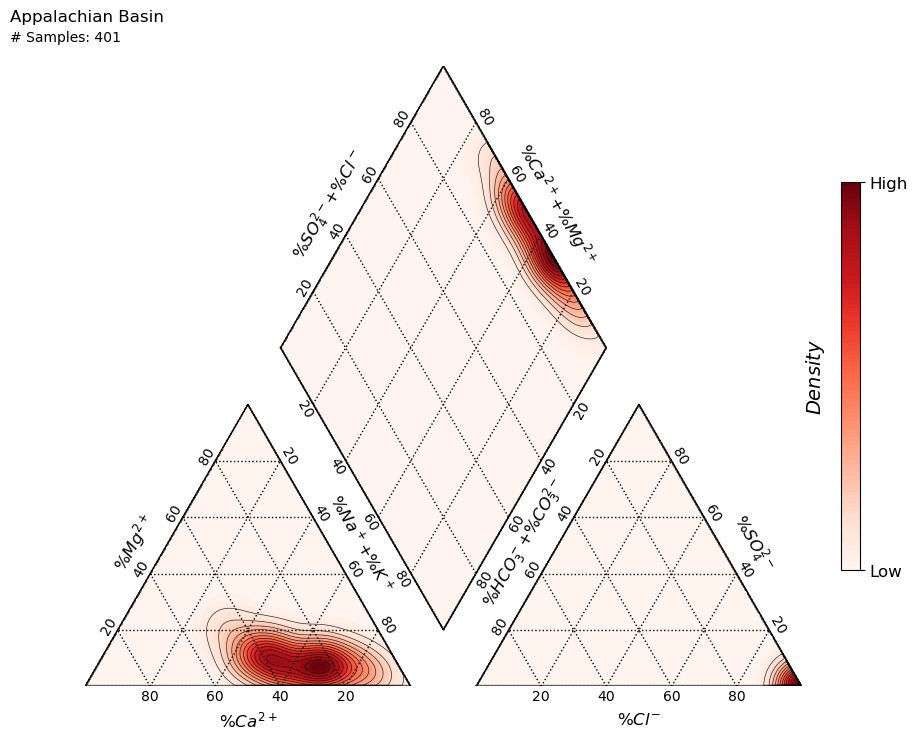

File 'AppalachianBasin_OnlyMostRecentWellSamples_Piper(Contour).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 206 samples from the Fort Worth Basin.
---
Patience please. The piper plot code may take a while to run.
---
Contour-filed Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



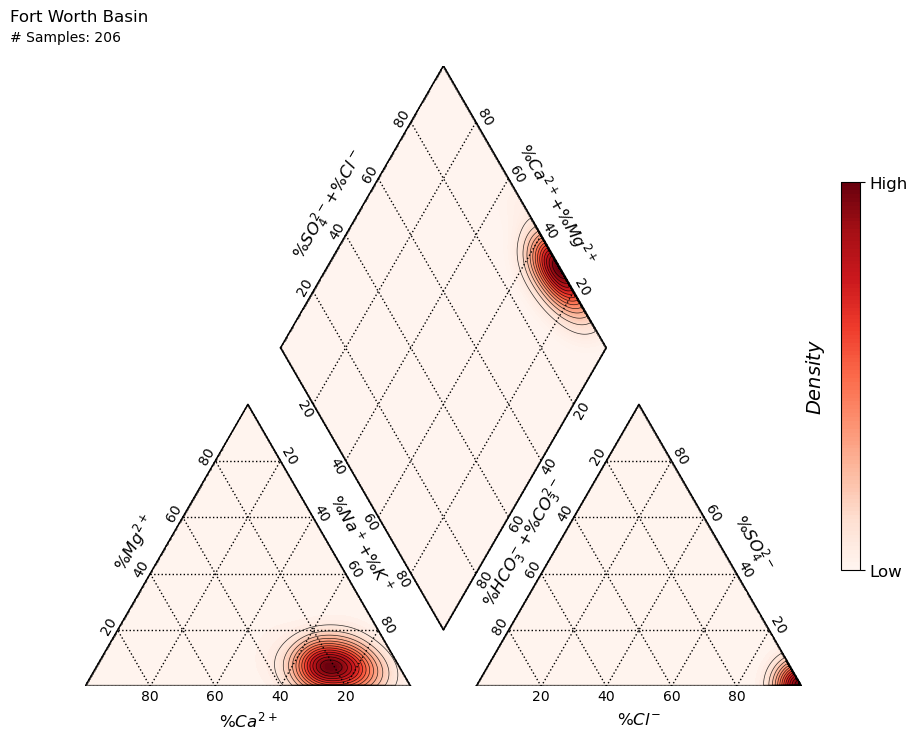

File 'FortWorthBasin_OnlyMostRecentWellSamples_Piper(Contour).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 345 samples from the Michigan Basin.
---
Patience please. The piper plot code may take a while to run.
---
Contour-filed Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



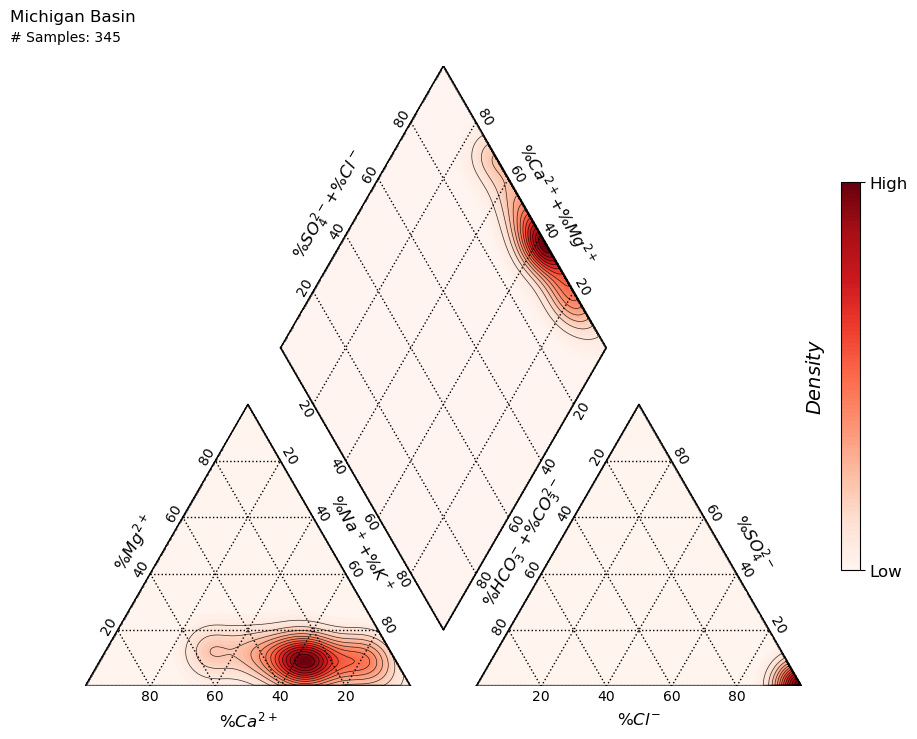

File 'MichiganBasin_OnlyMostRecentWellSamples_Piper(Contour).png' moved to 'images/piper_plots' folder.
---


In [22]:
# Generate all basin category contour piper plots that includes only the most recent sample from each well
basins = df_filtered_recent_categorized_basin['BASIN_CATEGORY'].unique()

for basin in basins:
    basin = basin
    piper_type = 'contour'
    image_name = f'{basin.replace(" ", "")}_OnlyMostRecentWellSamples_Piper(Contour)'
    image_type = 'piper'
    generate_single_basin_piper_plot(df_filtered_recent_categorized_basin, basin, piper_type, image_name, image_type)


### Generate Colorful Piper Plots: Most Recent Sample From Each Well Only

A dataframe called df_wqchartpyformat has been created that contains 7589 samples from the Gulf Coast Basin.
---
Patience please. The piper plot code may take a while to run.
---
Color-coded Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



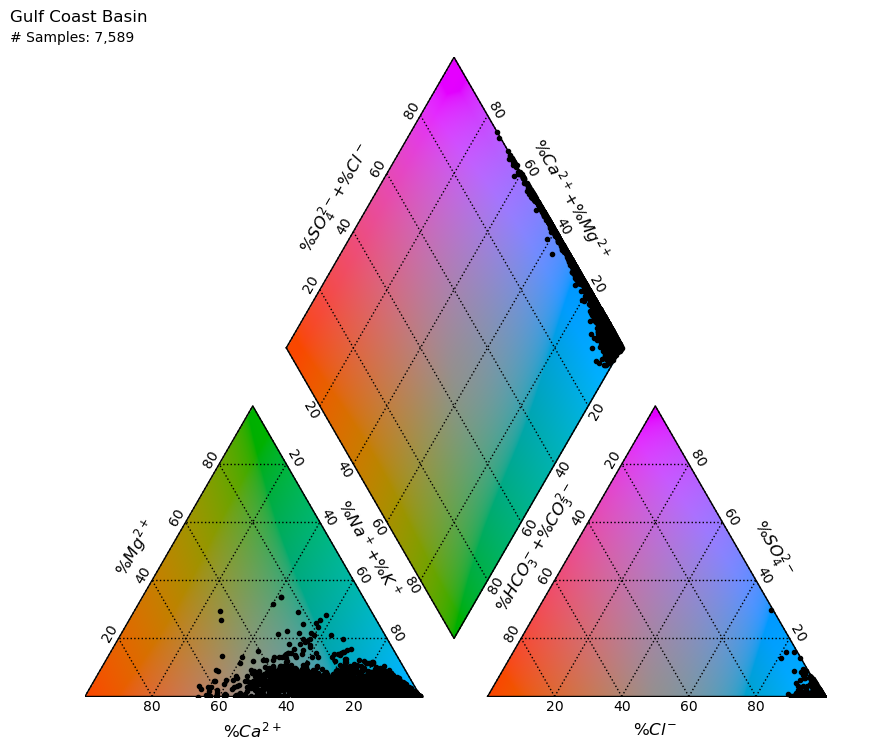

File 'GulfCoastBasin_OnlyMostRecentWellSamples_Piper(Color).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 4378 samples from the Permian Basin.
---
Patience please. The piper plot code may take a while to run.
---
Color-coded Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



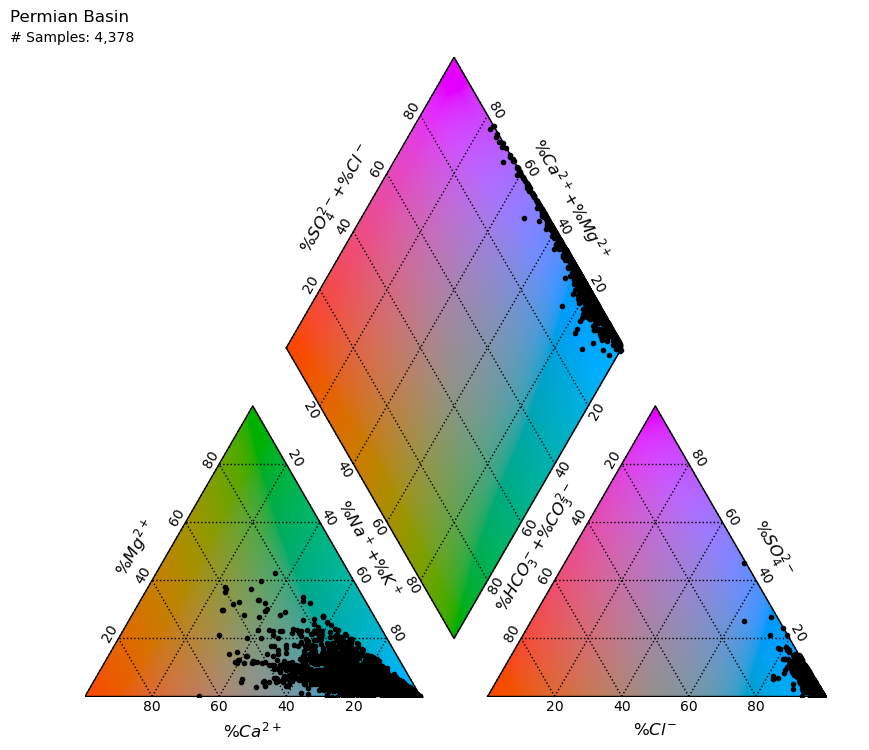

File 'PermianBasin_OnlyMostRecentWellSamples_Piper(Color).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 3582 samples from the Williston Basin.
---
Patience please. The piper plot code may take a while to run.
---
Color-coded Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



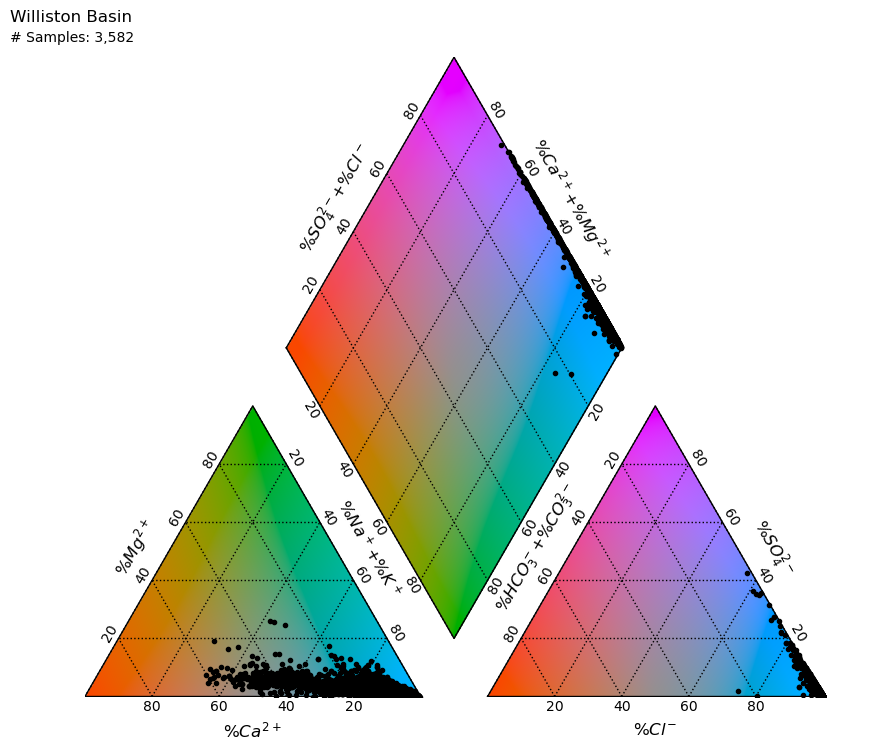

File 'WillistonBasin_OnlyMostRecentWellSamples_Piper(Color).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 1715 samples from the Rocky Mountain Basins.
---
Patience please. The piper plot code may take a while to run.
---
Color-coded Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



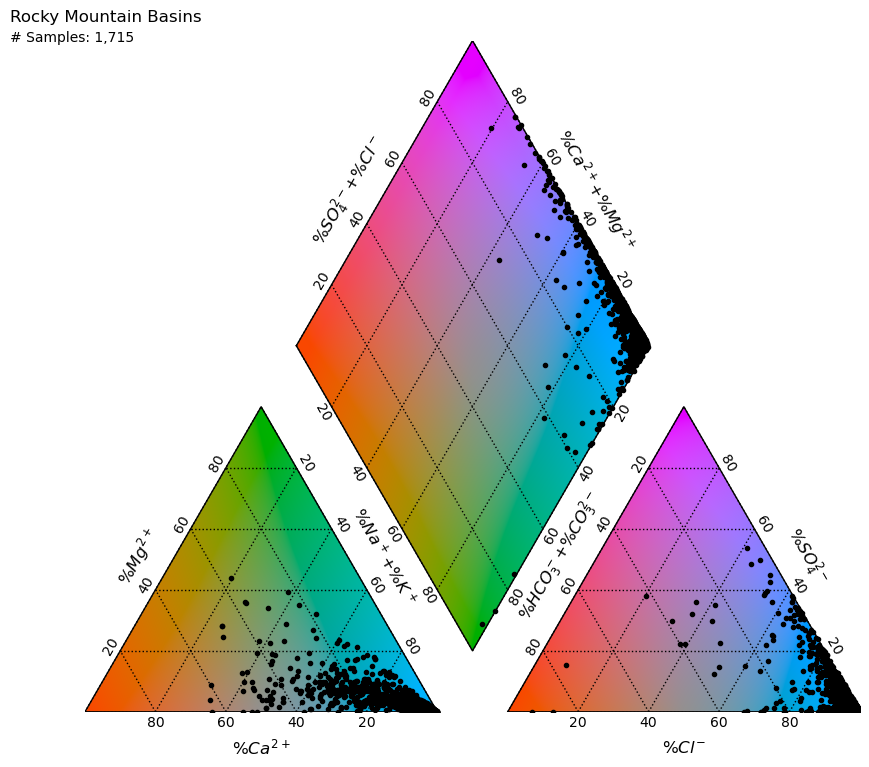

File 'RockyMountainBasins_OnlyMostRecentWellSamples_Piper(Color).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 5876 samples from the Oklahoma Platform Basins.
---
Patience please. The piper plot code may take a while to run.
---
Color-coded Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



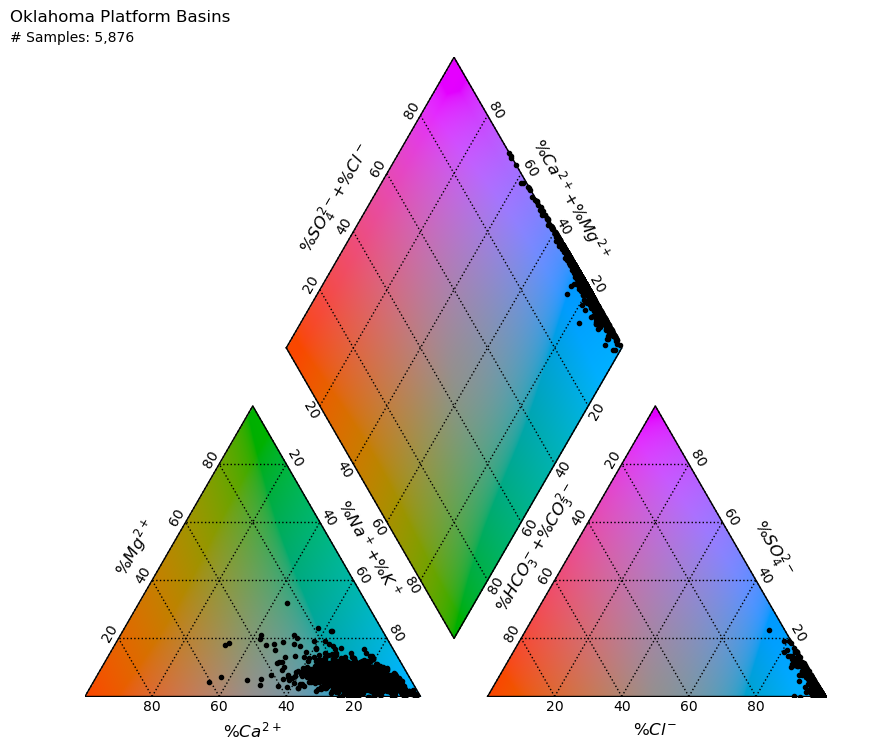

File 'OklahomaPlatformBasins_OnlyMostRecentWellSamples_Piper(Color).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 1460 samples from the Anadarko Basin.
---
Patience please. The piper plot code may take a while to run.
---
Color-coded Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



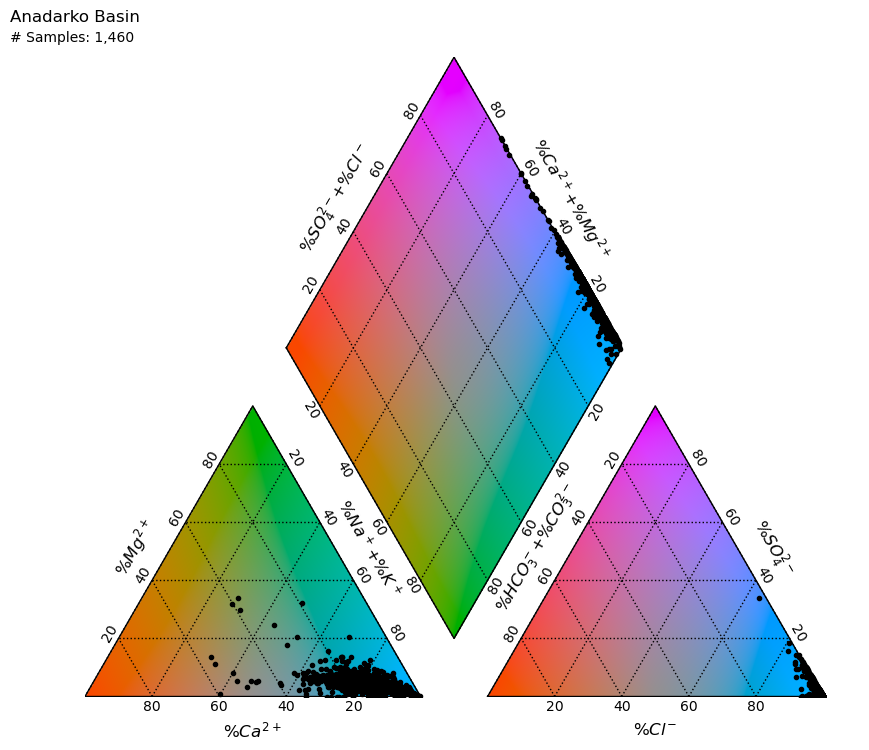

File 'AnadarkoBasin_OnlyMostRecentWellSamples_Piper(Color).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 866 samples from the Illinois Basin.
---
Patience please. The piper plot code may take a while to run.
---
Color-coded Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



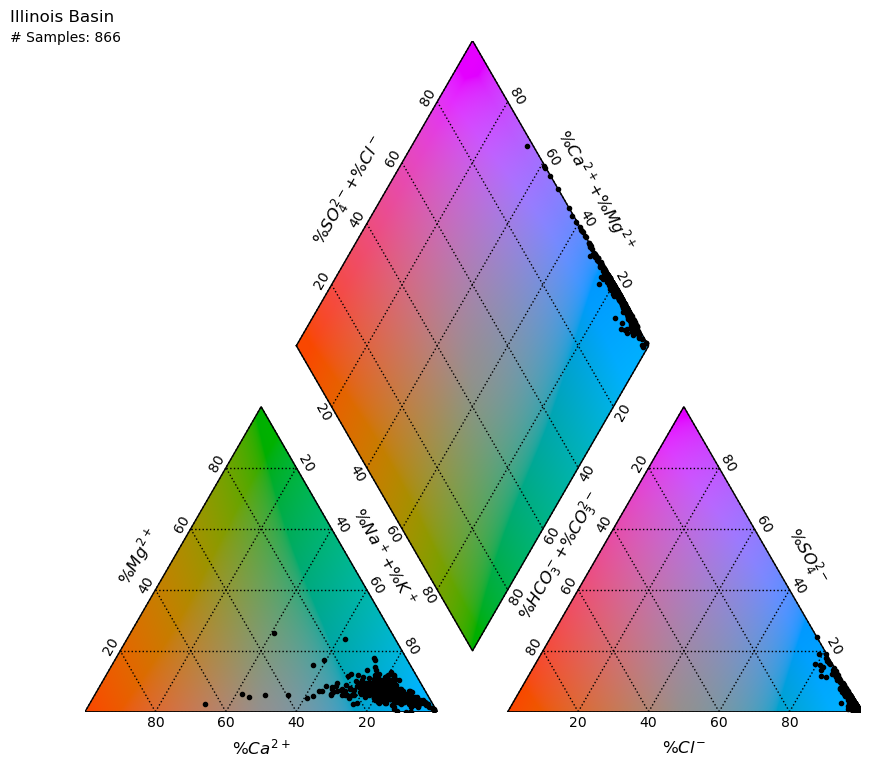

File 'IllinoisBasin_OnlyMostRecentWellSamples_Piper(Color).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 401 samples from the Appalachian Basin.
---
Patience please. The piper plot code may take a while to run.
---
Color-coded Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



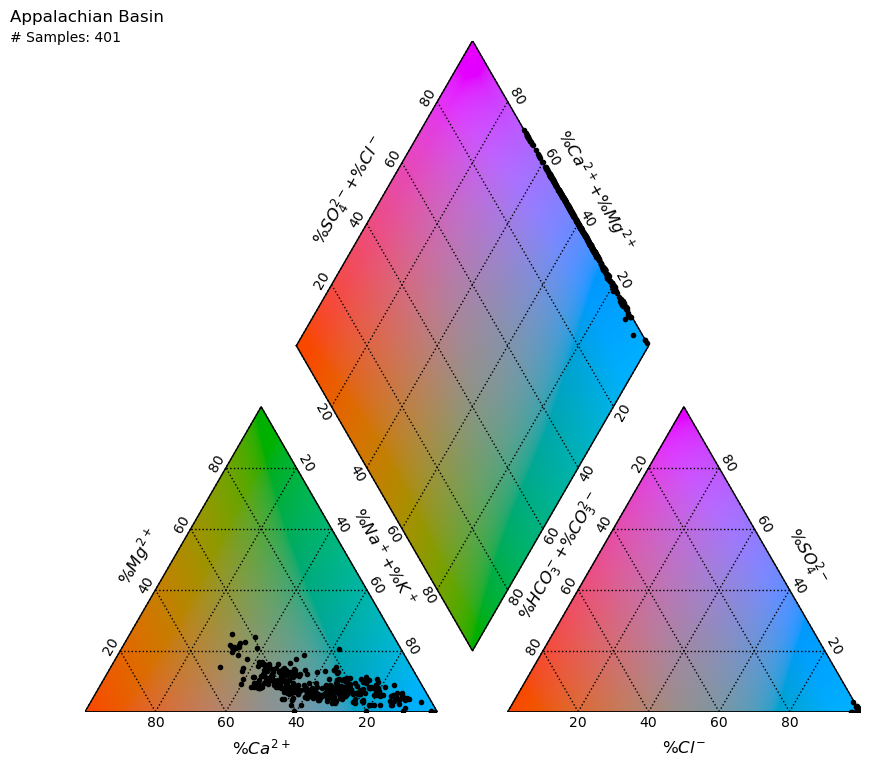

File 'AppalachianBasin_OnlyMostRecentWellSamples_Piper(Color).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 206 samples from the Fort Worth Basin.
---
Patience please. The piper plot code may take a while to run.
---
Color-coded Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



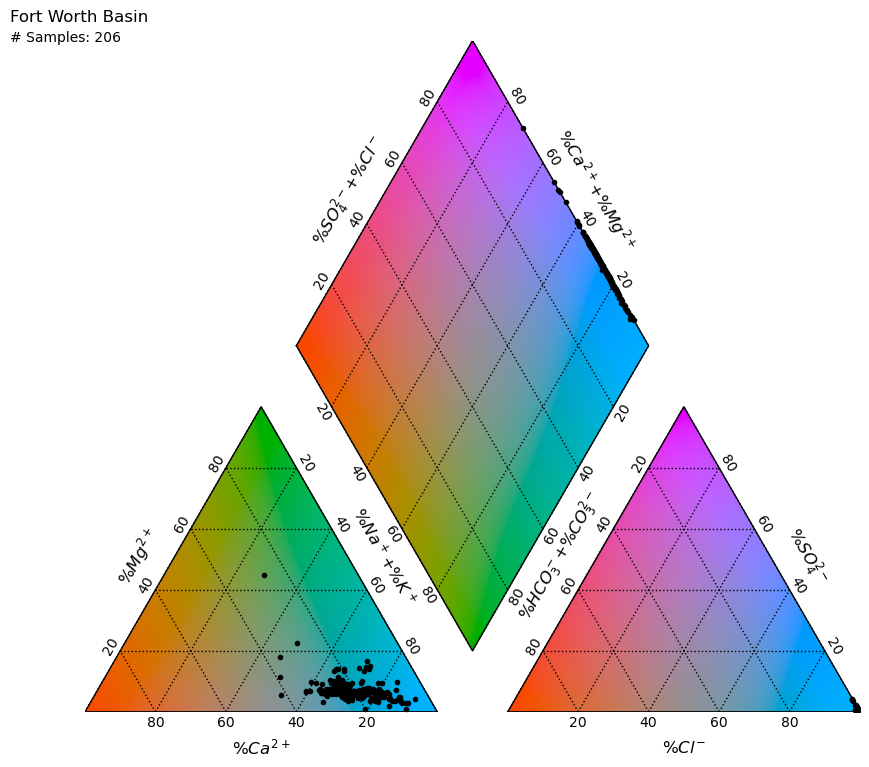

File 'FortWorthBasin_OnlyMostRecentWellSamples_Piper(Color).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 345 samples from the Michigan Basin.
---
Patience please. The piper plot code may take a while to run.
---
Color-coded Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



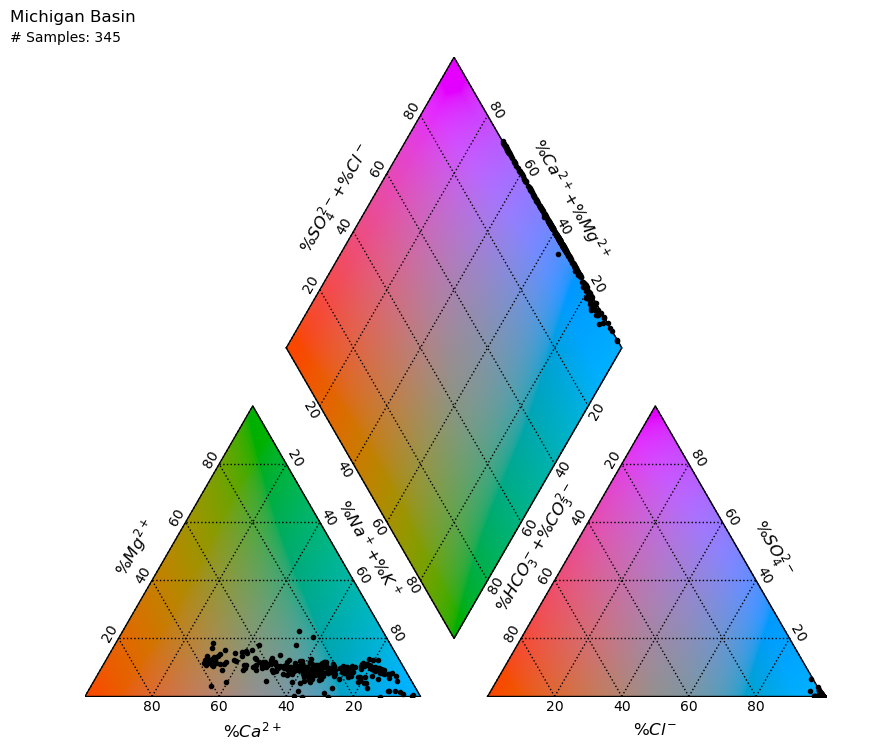

File 'MichiganBasin_OnlyMostRecentWellSamples_Piper(Color).png' moved to 'images/piper_plots' folder.
---


In [23]:
# Generate all basin category color piper plots that includes only the most recent sample from each well
basins = df_filtered_recent_categorized_basin['BASIN_CATEGORY'].unique()

for basin in basins:
    basin = basin
    piper_type = 'color'
    image_name = f'{basin.replace(" ", "")}_OnlyMostRecentWellSamples_Piper(Color)'
    image_type = 'piper'
    generate_single_basin_piper_plot(df_filtered_recent_categorized_basin, basin, piper_type, image_name, image_type)
    

### Generate Triangle Piper Plots: Most Recent Sample From Each Well Only

A dataframe called df_wqchartpyformat has been created that contains 7589 samples from the Gulf Coast Basin.
---
Patience please. The piper plot code may take a while to run.
---
Trilinear Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



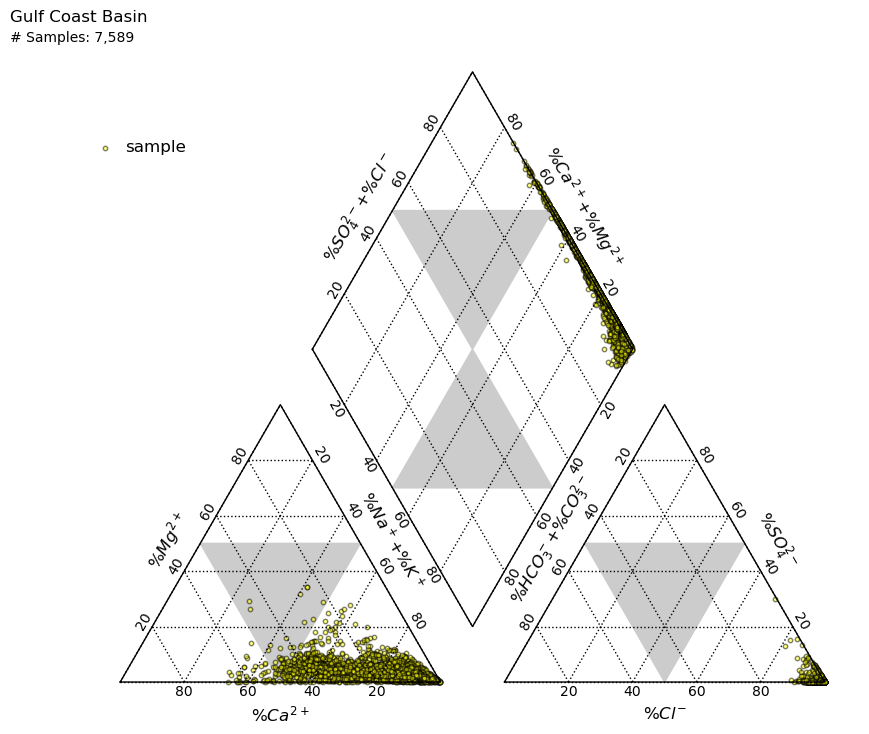

File 'GulfCoastBasin_OnlyMostRecentWellSamples_Piper(Triangle).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 4378 samples from the Permian Basin.
---
Patience please. The piper plot code may take a while to run.
---
Trilinear Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



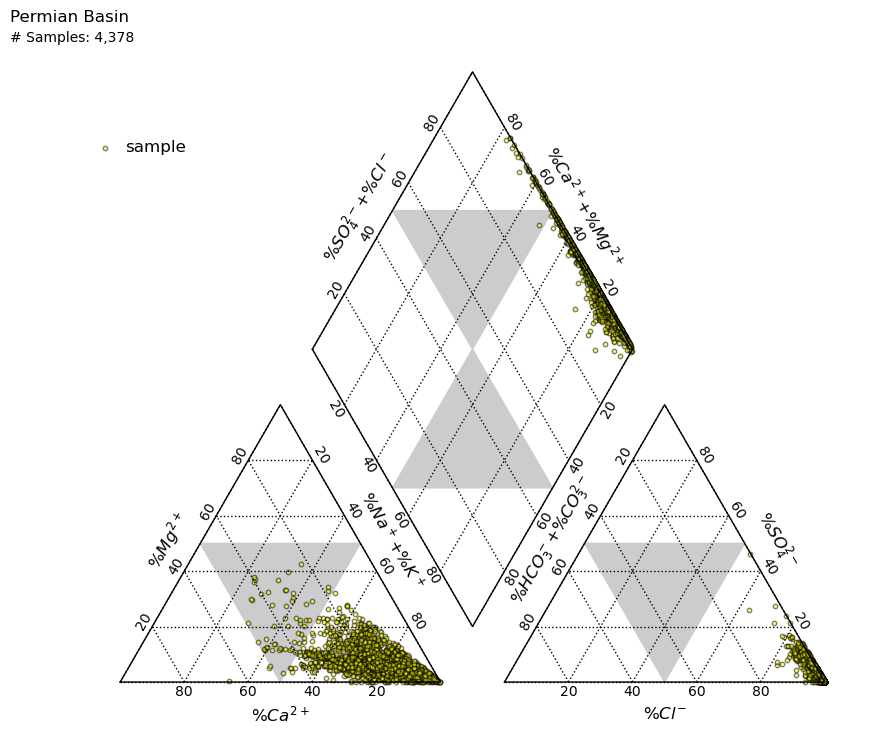

File 'PermianBasin_OnlyMostRecentWellSamples_Piper(Triangle).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 3582 samples from the Williston Basin.
---
Patience please. The piper plot code may take a while to run.
---
Trilinear Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



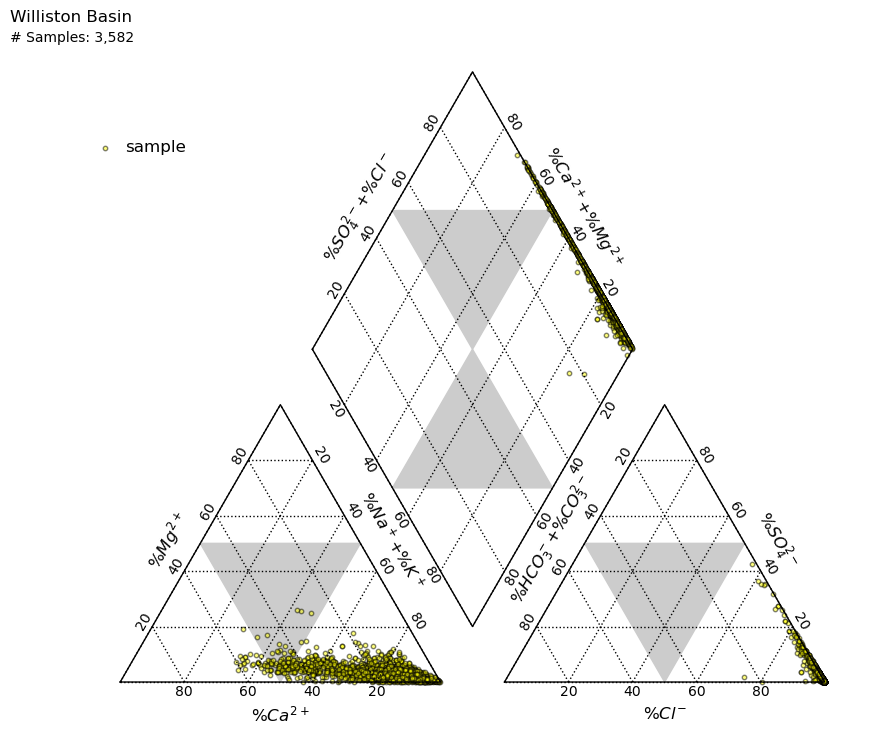

File 'WillistonBasin_OnlyMostRecentWellSamples_Piper(Triangle).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 1715 samples from the Rocky Mountain Basins.
---
Patience please. The piper plot code may take a while to run.
---
Trilinear Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



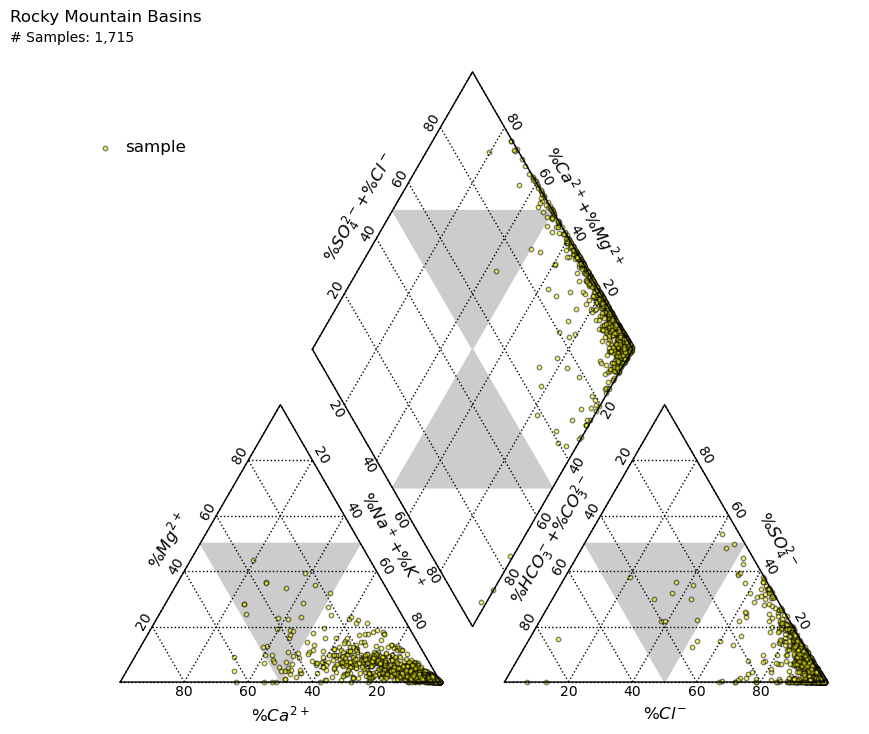

File 'RockyMountainBasins_OnlyMostRecentWellSamples_Piper(Triangle).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 5876 samples from the Oklahoma Platform Basins.
---
Patience please. The piper plot code may take a while to run.
---
Trilinear Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



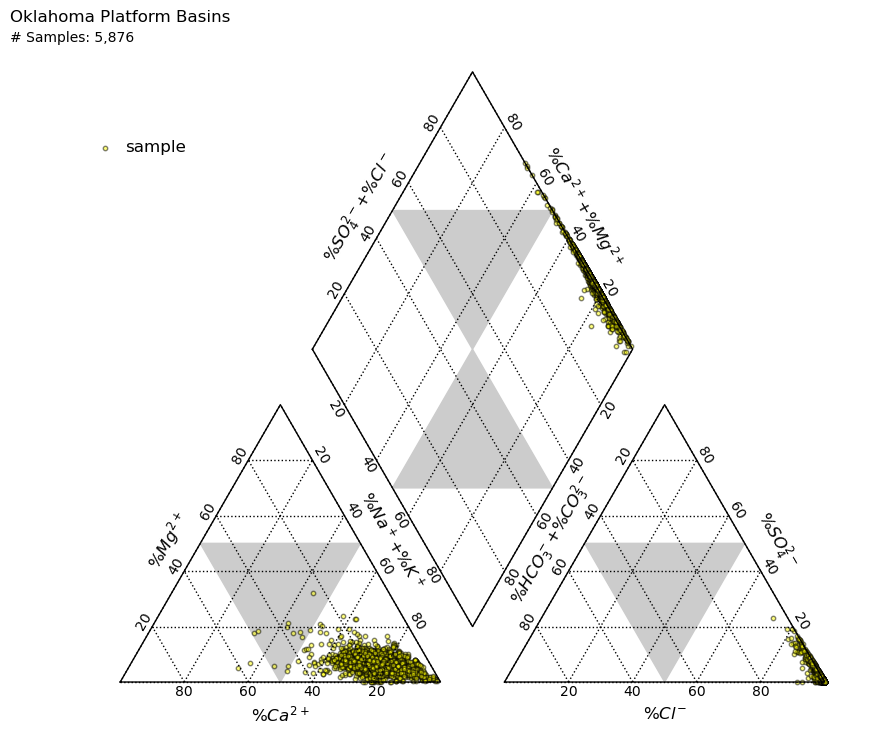

File 'OklahomaPlatformBasins_OnlyMostRecentWellSamples_Piper(Triangle).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 1460 samples from the Anadarko Basin.
---
Patience please. The piper plot code may take a while to run.
---
Trilinear Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



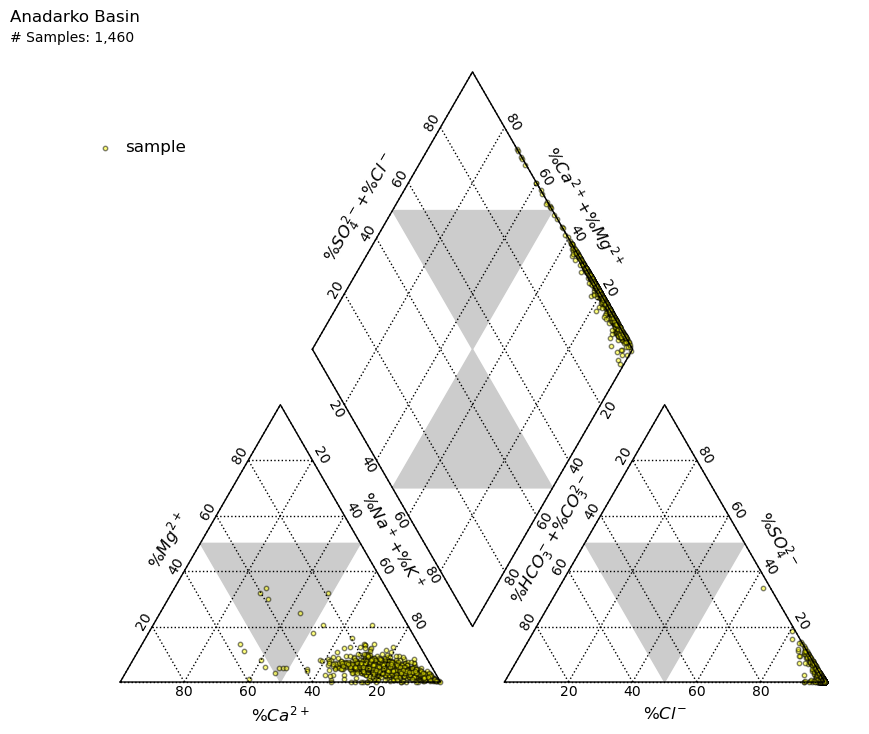

File 'AnadarkoBasin_OnlyMostRecentWellSamples_Piper(Triangle).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 866 samples from the Illinois Basin.
---
Patience please. The piper plot code may take a while to run.
---
Trilinear Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



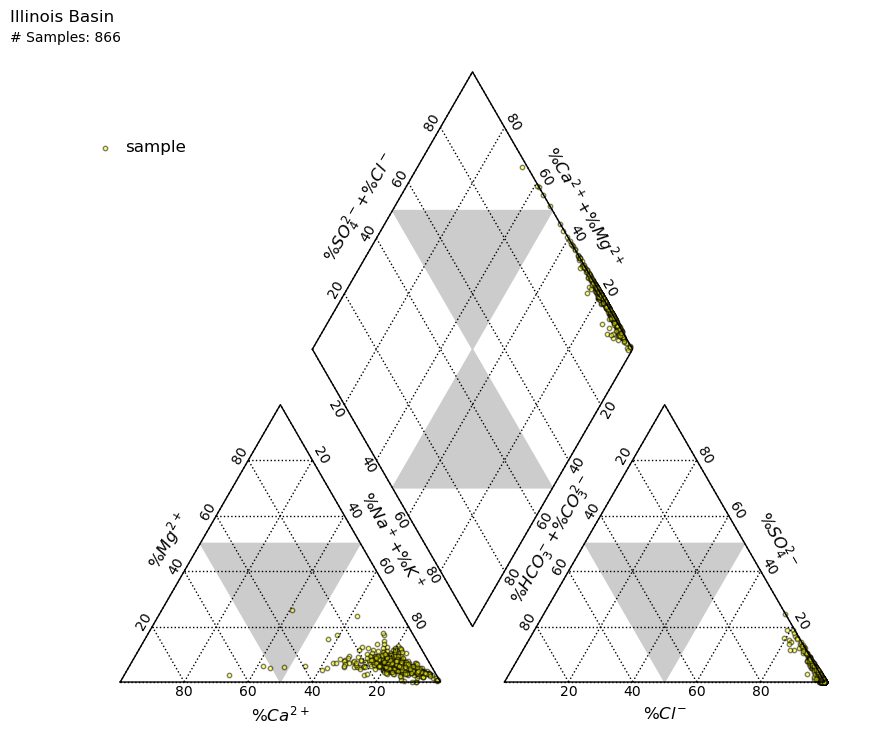

File 'IllinoisBasin_OnlyMostRecentWellSamples_Piper(Triangle).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 401 samples from the Appalachian Basin.
---
Patience please. The piper plot code may take a while to run.
---
Trilinear Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



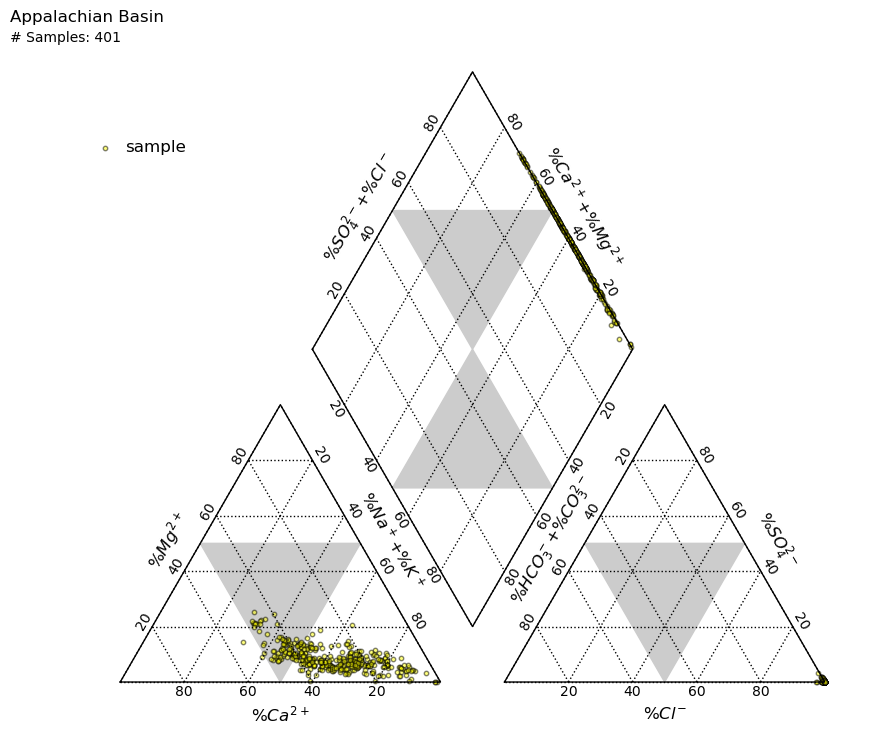

File 'AppalachianBasin_OnlyMostRecentWellSamples_Piper(Triangle).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 206 samples from the Fort Worth Basin.
---
Patience please. The piper plot code may take a while to run.
---
Trilinear Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



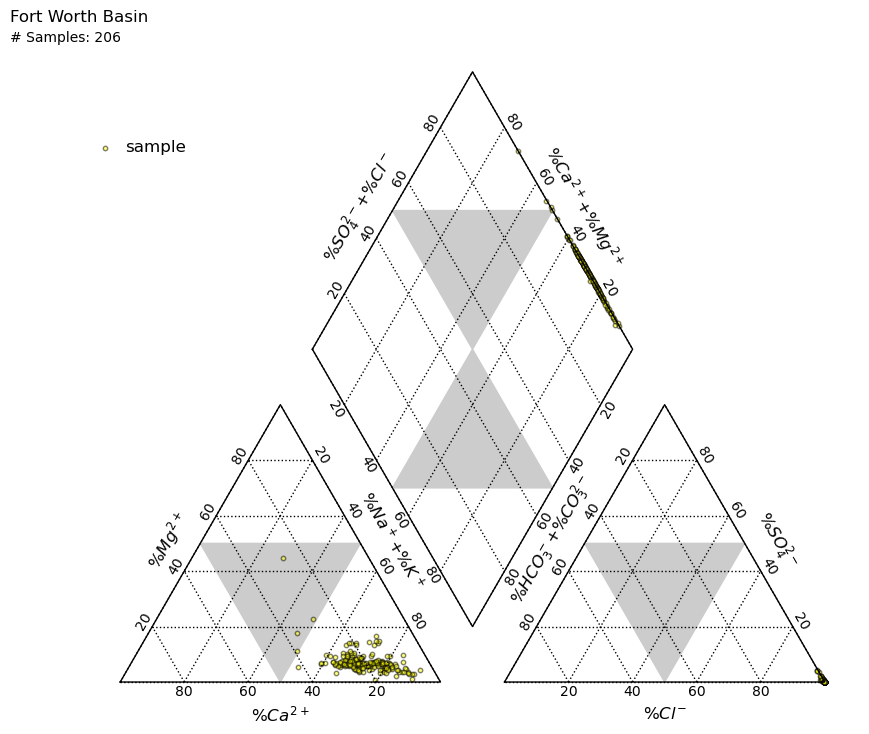

File 'FortWorthBasin_OnlyMostRecentWellSamples_Piper(Triangle).png' moved to 'images/piper_plots' folder.
---
A dataframe called df_wqchartpyformat has been created that contains 345 samples from the Michigan Basin.
---
Patience please. The piper plot code may take a while to run.
---
Trilinear Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 



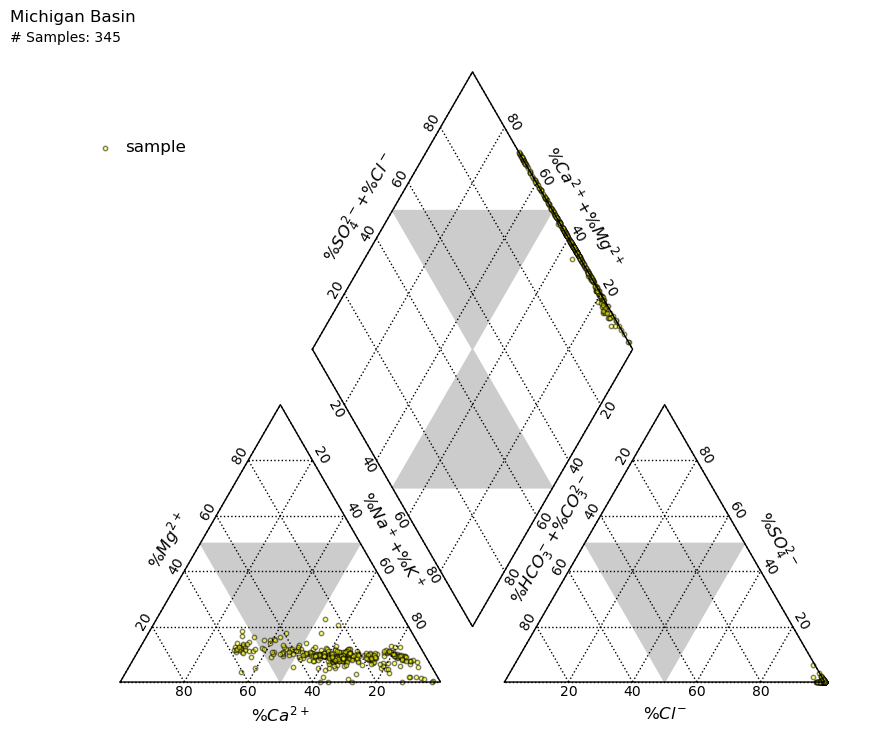

File 'MichiganBasin_OnlyMostRecentWellSamples_Piper(Triangle).png' moved to 'images/piper_plots' folder.
---


In [24]:
# Generate all basin category triangle piper plots that includes only the most recent sample from each well
basins = df_filtered_recent_categorized_basin['BASIN_CATEGORY'].unique()

for basin in basins:
    basin = basin
    piper_type = 'triangle'
    image_name = f'{basin.replace(" ", "")}_OnlyMostRecentWellSamples_Piper(Triangle)'
    image_type = 'piper'
    generate_single_basin_piper_plot(df_filtered_recent_categorized_basin, basin, piper_type, image_name, image_type)


### Generate Single Triangle Piper Plot with Target Basin Samples Color-Coded

In [25]:
# Filter dataframe to only show the target basins
target_basins = ['Gulf Coast Basin', 'Permian Basin', 'Anadarko Basin', 'Fort Worth Basin']
mask = df_filtered_recent_categorized_basin['BASIN_CATEGORY'].isin(target_basins)
df_filtered_recent_target_basins = df_filtered_recent_categorized_basin[mask]

# Create new dataframe to match format required by wqchartpy for the contour piper plot
df_wqchartpyformat = pd.DataFrame()
df_wqchartpyformat['Sample'] = df_filtered_recent_target_basins['IDUSGS'].map(str)
df_wqchartpyformat['Label'] = df_filtered_recent_target_basins['BASIN_CATEGORY'].map(str)
df_wqchartpyformat['Marker'] = 'o'
df_wqchartpyformat.loc[df_wqchartpyformat['Label']=='Gulf Coast Basin', 'Color'] = '#BA2F29'
df_wqchartpyformat.loc[df_wqchartpyformat['Label']=='Permian Basin', 'Color'] = '#E9C832'
df_wqchartpyformat.loc[df_wqchartpyformat['Label']=='Anadarko Basin', 'Color'] = '#89C667'
df_wqchartpyformat.loc[df_wqchartpyformat['Label']=='Fort Worth Basin', 'Color'] = '#67ACE6'
df_wqchartpyformat['Size'] = 10
df_wqchartpyformat['Alpha'] = 0.5

elements = ['Ca', 'Mg', 'Na', 'K', 'HCO3', 'CO3', 'Cl', 'SO4']
for element in elements:
    df_wqchartpyformat[element] = df_filtered_recent_target_basins[element]

# Reset the index
df_wqchartpyformat.reset_index(inplace=True, drop=True)

'''----------------------------------------'''

# Generate all basin category triangle piper plots that includes only the most recent sample from each well

image_name = f'AllTargetBasins_OnlyMostRecentWellSamples_Piper(Triangle)'
triangle_piper.plot(df_wqchartpyformat,unit='mg/L',figname=image_name,figformat='png')

plt.text(0.05, 0.85, f'Target Basins: {target_basins[0]}, {target_basins[1]}, {target_basins[2]}, {target_basins[3]}', color='black', fontsize=12, ha='left', transform=plt.gcf().transFigure)
plt.text(0.05, 0.83, f'# Samples: {len(df_wqchartpyformat):,} (Total), {df_wqchartpyformat['Label'].value_counts().get('Gulf Coast Basin', 0):,} (Gulf Coast), {df_wqchartpyformat['Label'].value_counts().get('Permian Basin', 0):,} (Permian), {df_wqchartpyformat['Label'].value_counts().get('Anadarko Basin', 0):,} (Anadarko), {df_wqchartpyformat['Label'].value_counts().get('Fort Worth Basin', 0):,} (Fort Worth)', 
         color='black', fontsize=10, ha='left', transform=plt.gcf().transFigure)

plt.savefig(f'{image_name}.png', format='png', bbox_inches='tight', dpi=300)
plt.show()

image_file_name = f'{image_name}.png'
image_type = 'piper'
move_image_file_to_images_folder(image_file_name, image_type)


SyntaxError: unterminated string literal (detected at line 33) (1401879235.py, line 33)

### Geo Plots